This notebook implements Feature K-Means clustering on time series data by first transforming them into a high-dimensional feature space combining both time and frequency information. The K-Means algorithm itself uses the standard Euclidean distance but operates on this extracted feature matrix, enabling efficient clustering based on comprehensive signal characteristics. This method focuses on clustering based on the frequency, amplitude, and statistical properties of the series, rather than relying solely on time-domain shape differences.The notebook covers the following steps:
1. Data Loading and Preprocessing: Loads the raw multivariate time series data and applies Z-normalization to each individual time series.
2. Feature Augmentation: Augments the Z-normalized data by calculating and appending the discrete derivative of each channel, creating an augmented tensor to capture the rate of change.
3. Time Feature Extraction: Computes statistical Time Features (mean, standard deviation, min/max, energy, skewness, kurtosis, and overall magnitude statistics) from the augmented time series data.
4. Frequency Feature Extraction: Computes the amplitude spectrum using the Fast Fourier Transform (FFT) and extracts the N most dominant low-frequency coefficients to create the frequency feature set.
5. Feature Consolidation: Concatenates the extracted Time Features and Frequency Features into a single comprehensive feature matrix.
6. Feature Scaling: Applies Standard Scaling (Z-score normalization) to the combined feature matrix.
7. Dimensionality Reduction (PCA): Applies Principal Component Analysis (PCA) to the scaled feature matrix, primarily to decorrelate features and reduce dimensionality. 
8. Clustering Execution: Runs the standard K-Means clustering algorithm on the reduced feature matrix.
9. Evaluation and Visualization: Computes external metrics (ARI, NMI, Purity) and an internal metric (Euclidean Silhouette Score). The results are visualized using UMAP on the PCA features and a Hungarian-aligned Confusion Matrix.

1. Import Libraries

In [ ]:
import sys; sys.path.append("..")
import numpy as np
from src.io import load_dataset
from src.preprocess import z_norm_per_series
from src.eval import external_scores, confusion_with_hungarian, silhouette_by_metric
from src.viz import embed_tsne_from_dist, scatter_2d, plot_confusion_matrix
from src.utils_io import save_clustering_results
from src.fft import compute_fft_spectrum, extract_fourier_features
from src.kmeans import run_kmeans
from src.distances import distance_matrix
from src.reducers import apply_pca
from src.time_features import add_derivative_channels, compute_time_features, scale_features, concatenate_features
from itertools import product
import pandas as pd
import time

2. Define Hyperparameters

In [ ]:
N_CLUSTERS = 6
N_INIT = 15
MAX_ITER = 50
RANDOM_STATE = 42
SAMPLING_RATE = 51.2
N_FOURIER_COEFFS = 16
SVD_SOLVER = "full"
N_COMPONENTS = 0.99	

2. Load Data and preprocessign

In [ ]:
# Load dataset
X_train, X_test, y_train, y_test = load_dataset("../data/raw", test_size=0.2, random_state=42)

# Preprocessing: z-normalization (per series)
Xn_train = z_norm_per_series(X_train)
Xn_test  = z_norm_per_series(X_test)

# Add Derivative Channels
Xn_train_deriv = add_derivative_channels(Xn_train)

3. Extract Fourier Features

In [ ]:
freqs, amp = compute_fft_spectrum(
    X=Xn_train_deriv, 
    sampling_rate=SAMPLING_RATE, 
    center=True
)
X_freq = extract_fourier_features(amp, n_coeffs=N_FOURIER_COEFFS)

4. Feature Engineering

In [ ]:
X_time = compute_time_features(Xn_train_deriv)

5. Feature Concatenationand scaling

In [ ]:
X_feat = concatenate_features(X_time, X_freq)
X_feat_scaled = scale_features(X_feat)

6. Apply PCA for Dimensionality Reduction

In [ ]:
X_pca = apply_pca(X_feat_scaled, n_components=N_COMPONENTS, svd_solver=SVD_SOLVER)

7. Execute k-Means Clustering

In [ ]:
y_pred, model, centers = run_kmeans(
    X=X_pca,
    n_clusters=N_CLUSTERS,
    n_init=N_INIT,
    max_iter=MAX_ITER,
    random_state=RANDOM_STATE
)

8. Evaluation

In [ ]:
scores = external_scores(y_train, y_pred)

y_pred_mapped, C, mapping = confusion_with_hungarian(y_train, y_pred)
mapping_clean = {int(k): int(v) for k, v in mapping.items()}

D = distance_matrix(X_pca)                 
sil = silhouette_by_metric(X_pca, y_pred, metric="euclidean")
scores["Silhouette_Euclidean"] = float(sil)
print("Final scores:", scores)
X2 = embed_tsne_from_dist(D, perplexity=30, random_state=42)
fig = scatter_2d(X2, y_pred, "k-Shape — t-SNE on SBD distances", y_true=y_train, show=True)

true_labels = np.sort(np.unique(y_train))
pred_labels = np.sort(np.unique(y_pred))
fig = plot_confusion_matrix(
    C, true_labels, pred_labels,
    label_to_activity={1:"Walk",2:"Stairs Up",3:"Stairs Down",4:"Sit",5:"Stand",6:"Lay"},
    normalize=True,
    title="k-Shape Confusion Matrix (Hungarian Aligned)",
    show=True
)

9. Grid Search

In [ ]:
#CONFIG 
RESULTS_DIR  = "../results"
METHOD_NAME  = "fourier_kmeans_2"

# Grid Search Parameters and PCA Settings
N_CLUSTERS_LIST        = [6]             
N_INIT_LIST            = [15, 20, 25]     
MAX_ITER_LIST          = [50, 100]   
N_FOURIER_COEFFS_LIST  = [16, 24]         
N_COMPONENTS_LIST      = [0.95, 0.98]     
SVD_SOLVER_LIST        = ["full"] 
RANDOM_SEEDS           = [42]     

SAMPLING_RATE   = 51.2
COMPUTE_EMBEDDING = True
SAVE_FIGURES      = True
SUBSAMPLE_RATIO   = 1.0

In [ ]:
# Preprocessing: z-normalization (per series)
Xn_train = z_norm_per_series(X_train)
Xn_test  = z_norm_per_series(X_test)

#add derivative channels
Xn_train_deriv = add_derivative_channels(Xn_train)

#calculate amplitude spectrum
freqs, amp = compute_fft_spectrum(
    X=Xn_train_deriv, 
    sampling_rate=SAMPLING_RATE, 
    center=True
)

#features extraction - time domain
X_time = compute_time_features(Xn_train_deriv)

#Labels
ytrue = y_train.copy()

# Subsample optionnel
if SUBSAMPLE_RATIO < 1.0:
    rng = np.random.default_rng(0)
    idx = rng.choice(len(ytrue), size=int(len(ytrue) * SUBSAMPLE_RATIO), replace=False)
    X_time = X_time[idx]
    amp    = amp[idx]
    ytrue  = ytrue[idx]


In [ ]:
def run_one(n_clusters, n_init, max_iter,
            n_fourier_coeffs, n_components, svd_solver, seed):
    t0 = time.time()

    # ---- Features freq  ----
    X_freq = extract_fourier_features(amp, n_coeffs=n_fourier_coeffs)

    # ---- Concat time + freq ----
    X_feat = concatenate_features(X_time, X_freq)

    # ---- Scaling ----
    X_feat_scaled = scale_features(X_feat)

    # ---- PCA ----
    X_pca = apply_pca(
        X_feat_scaled,
        n_components=n_components,
        svd_solver=svd_solver
    )

    # ---- K-Means ----
    y_pred, model, centers = run_kmeans(
        X=X_pca,
        n_clusters=n_clusters,
        n_init=n_init,
        max_iter=max_iter,
        random_state=seed
    )

    # ---- Scores ----
    sil = silhouette_by_metric(X_pca, y_pred, metric="euclidean")
    scores = external_scores(ytrue, y_pred)
    scores["Silhouette_Euclidean"] = float(sil)

    # Mapping & confusion (Hungarian)
    y_pred_mapped, C, mapping = confusion_with_hungarian(ytrue, y_pred)
    mapping_clean = {int(k): int(v) for k, v in mapping.items()}

    # Distances + embedding 2D
    D = X2 = None
    if COMPUTE_EMBEDDING:
        D  = distance_matrix(X_pca)
        X2 = embed_tsne_from_dist(D, perplexity=30, random_state=seed)

    params = {
        "n_clusters": n_clusters,
        "n_init": n_init,
        "max_iter": max_iter,
        "n_fourier_coeffs": n_fourier_coeffs,
        "n_components": n_components,
        "svd_solver": svd_solver,
        "random_state": seed,
        "metric": "euclidean_fft_pca",
        "sampling_rate": SAMPLING_RATE,
    }

    root, arr_dir, fig_dir, run_id = save_clustering_results(
        method_name=METHOD_NAME,
        y_pred=y_pred,
        y_true=ytrue,
        scores=scores,
        centers=centers,
        mapping=mapping_clean,
        embedding_2d=X2,
        dist_matrix=D,
        confusion=C,
        labels_true=np.sort(np.unique(ytrue)),
        labels_pred=np.sort(np.unique(y_pred)),
        params=params,
        output_dir=RESULTS_DIR,
        run_id=None
    )

    if SAVE_FIGURES and X2 is not None:
        import matplotlib.pyplot as plt

        fig = scatter_2d(
            X2,
            y_pred,
            title=(f"Fourier+Time+PCA k-means — t-SNE "
                   f"(k={n_clusters}, n_fft={n_fourier_coeffs}, "
                   f"pca={n_components}, solver={svd_solver})"),
            y_true=ytrue,
            show=True
        )
        fig.savefig(f"{fig_dir}/scatter_tsne.png", dpi=150)
        plt.close(fig)

        fig = plot_confusion_matrix(
            C,
            labels_true=np.sort(np.unique(ytrue)),
            labels_pred=np.sort(np.unique(y_pred)),
            label_to_activity={1:"Walk",2:"Stairs Up",3:"Stairs Down",
                               4:"Sit",5:"Stand",6:"Lay"},
            normalize=True,
            title="Fourier+Time+PCA k-means Confusion Matrix (Hungarian Aligned)",
            show=True
        )
        fig.savefig(f"{fig_dir}/confusion_matrix_norm.png", dpi=150)
        plt.close(fig)

    elapsed = time.time() - t0
    return {
        "run_dir": root,
        "run_id": run_id,
        "params": params,
        "scores": scores,
        "time_sec": elapsed
    }

--> k=6 | n_init=15 | max_iter=50 | n_fft=16 | n_comp=0.95 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-20_seed42


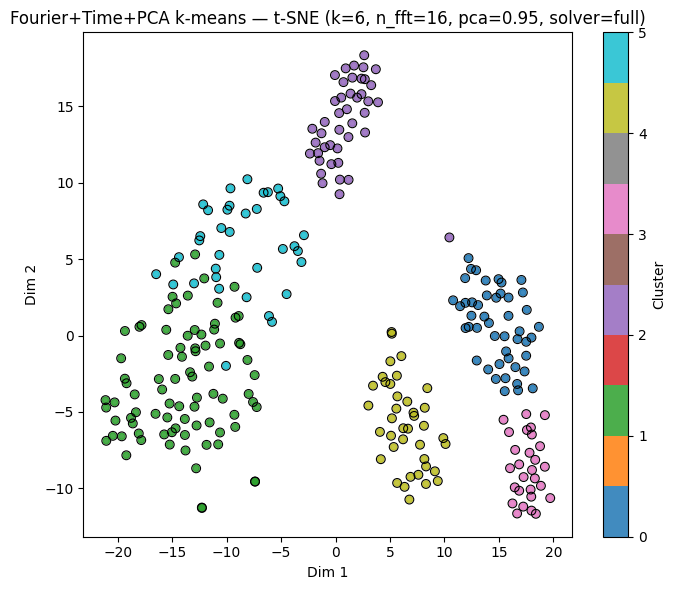

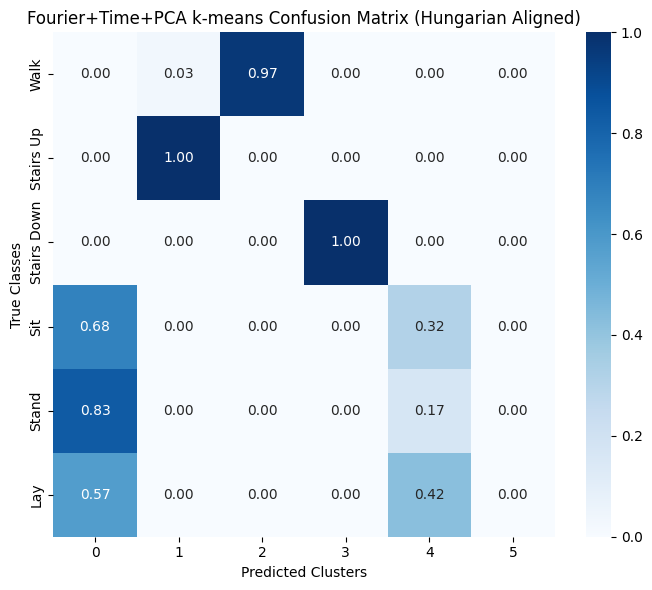

ARI=0.554  NMI=0.732  Sil=0.131  time=1.2s   -> 2025-11-14_13-31-20_seed42
--> k=6 | n_init=15 | max_iter=50 | n_fft=16 | n_comp=0.98 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-22_seed42


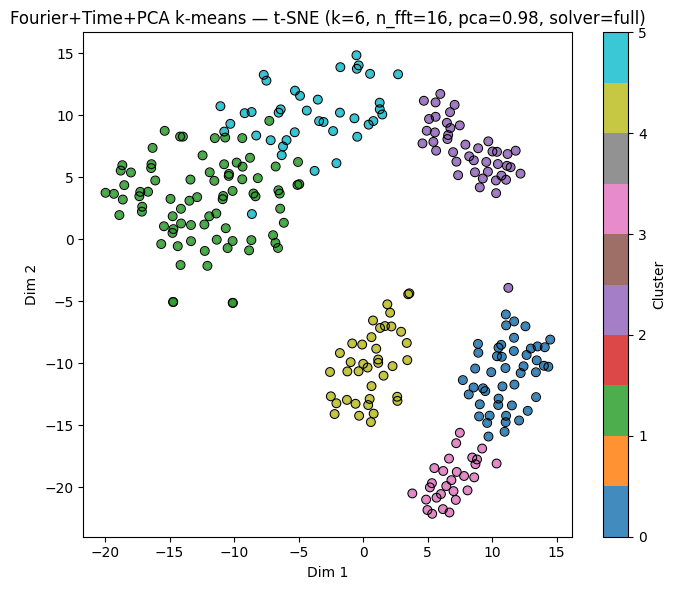

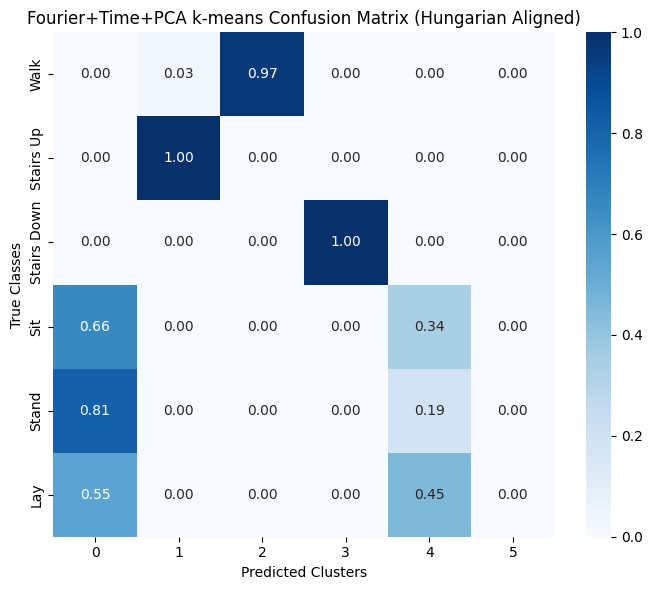

ARI=0.555  NMI=0.730  Sil=0.124  time=1.3s   -> 2025-11-14_13-31-22_seed42
--> k=6 | n_init=15 | max_iter=50 | n_fft=24 | n_comp=0.95 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-23_seed42


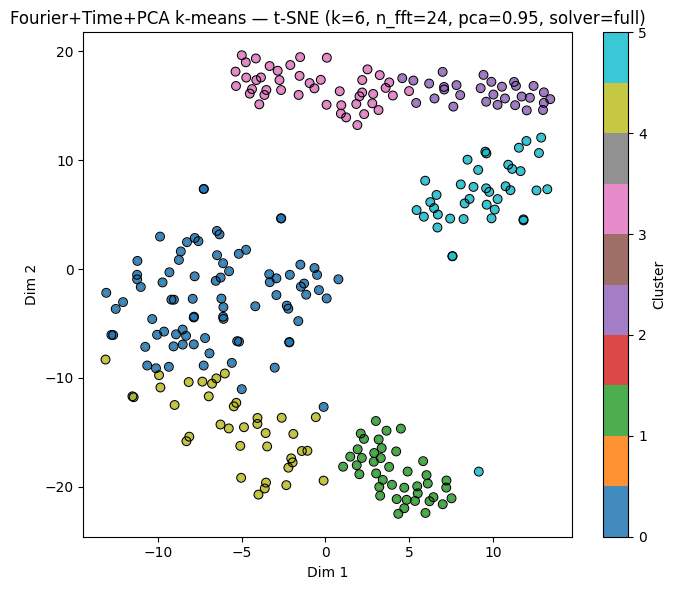

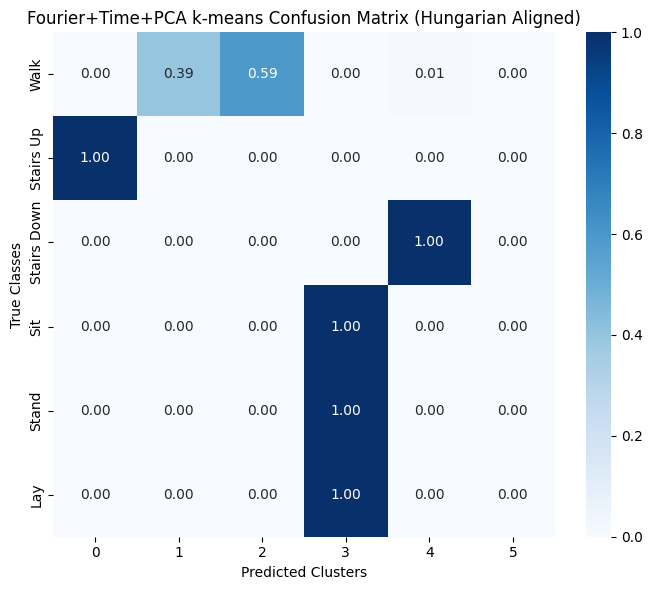

ARI=0.548  NMI=0.729  Sil=0.120  time=1.3s   -> 2025-11-14_13-31-23_seed42
--> k=6 | n_init=15 | max_iter=50 | n_fft=24 | n_comp=0.98 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-24_seed42


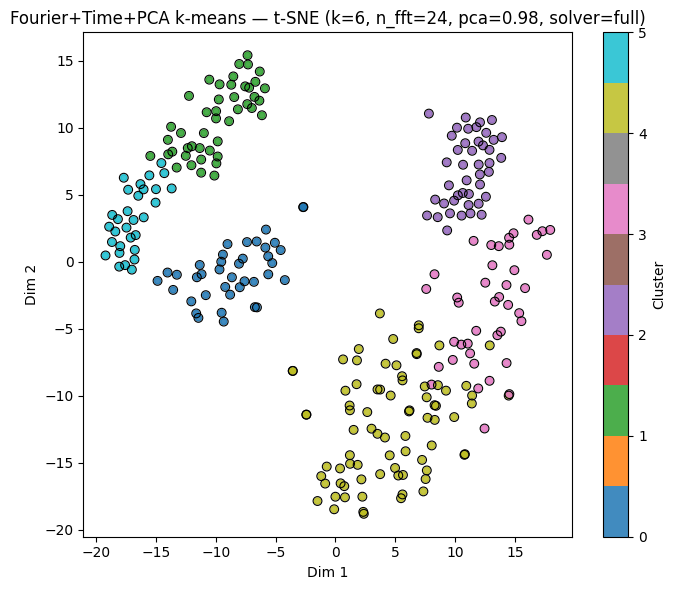

c:\projetsUniversite\Master_2\clustering\human_activity_clustering\notebooks\..\src\viz.py:352: RuntimeWarning: invalid value encountered in divide
  C_display = C_display / C_display.sum(axis=1, keepdims=True)


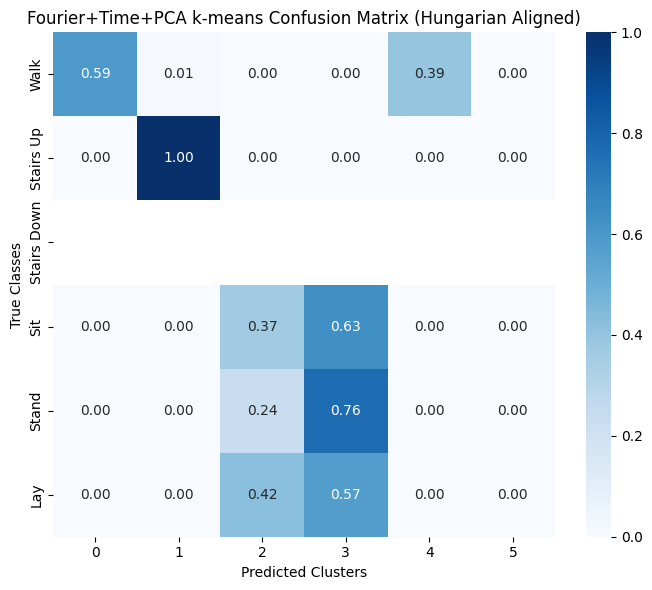

ARI=0.547  NMI=0.725  Sil=0.114  time=1.2s   -> 2025-11-14_13-31-24_seed42
--> k=6 | n_init=15 | max_iter=100 | n_fft=16 | n_comp=0.95 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-26_seed42


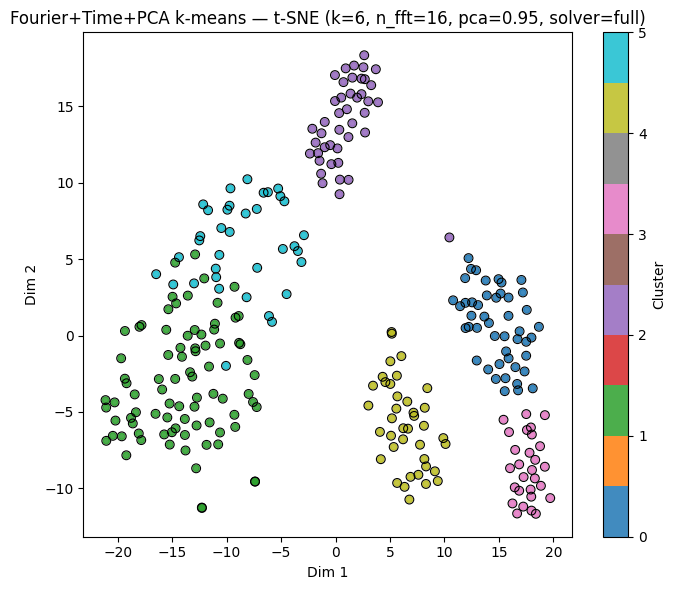

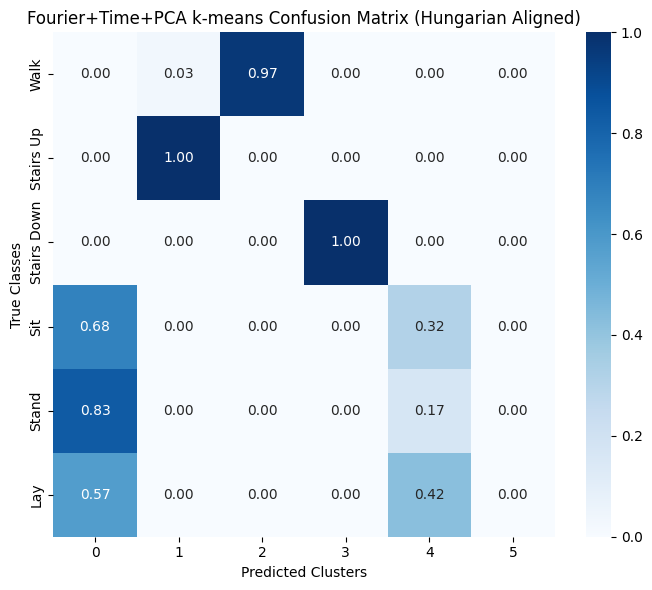

ARI=0.554  NMI=0.732  Sil=0.131  time=1.4s   -> 2025-11-14_13-31-26_seed42
--> k=6 | n_init=15 | max_iter=100 | n_fft=16 | n_comp=0.98 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-27_seed42


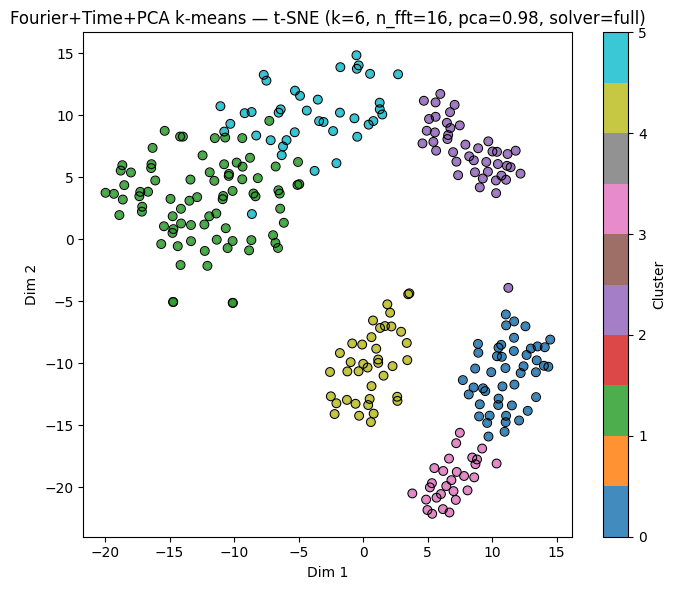

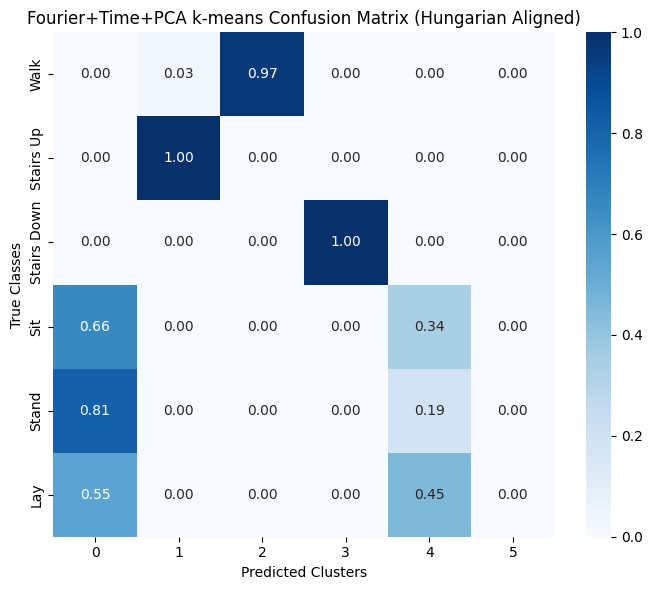

ARI=0.555  NMI=0.730  Sil=0.124  time=1.2s   -> 2025-11-14_13-31-27_seed42
--> k=6 | n_init=15 | max_iter=100 | n_fft=24 | n_comp=0.95 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-28_seed42


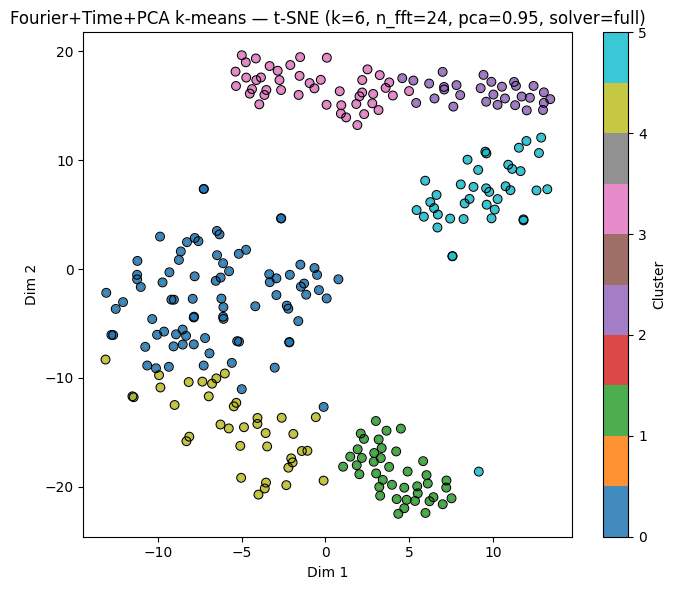

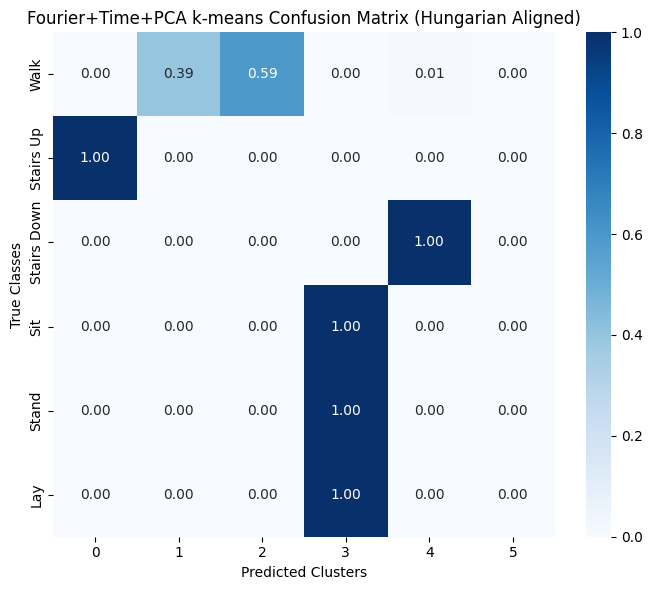

ARI=0.548  NMI=0.729  Sil=0.120  time=1.2s   -> 2025-11-14_13-31-28_seed42
--> k=6 | n_init=15 | max_iter=100 | n_fft=24 | n_comp=0.98 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-30_seed42


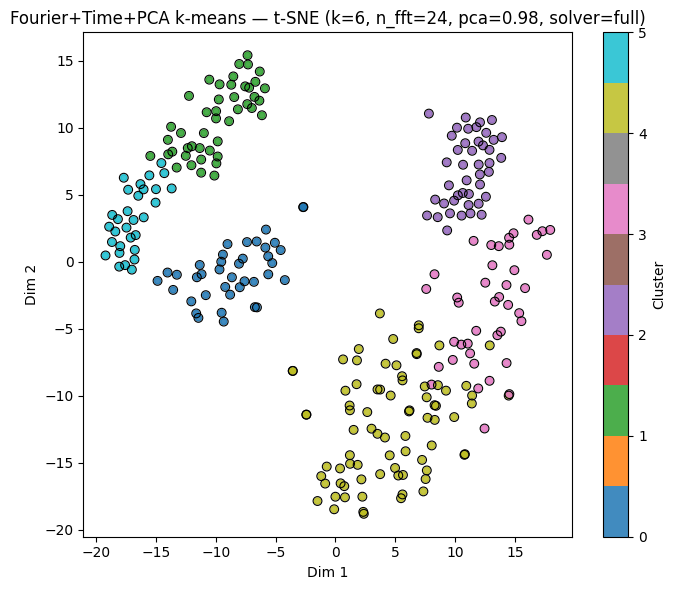

c:\projetsUniversite\Master_2\clustering\human_activity_clustering\notebooks\..\src\viz.py:352: RuntimeWarning: invalid value encountered in divide
  C_display = C_display / C_display.sum(axis=1, keepdims=True)


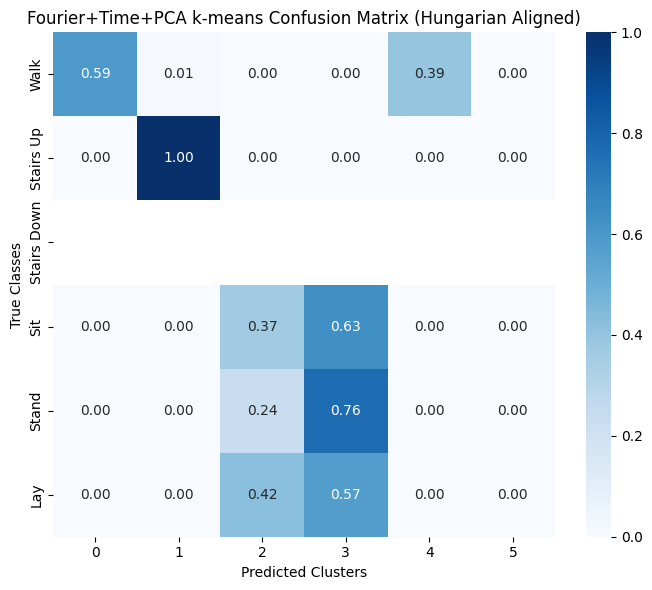

ARI=0.547  NMI=0.725  Sil=0.114  time=1.9s   -> 2025-11-14_13-31-30_seed42
--> k=6 | n_init=20 | max_iter=50 | n_fft=16 | n_comp=0.95 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-32_seed42


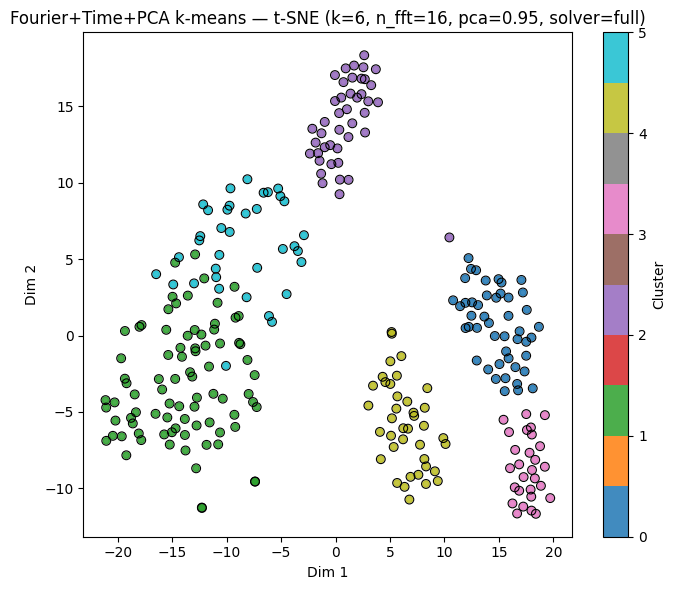

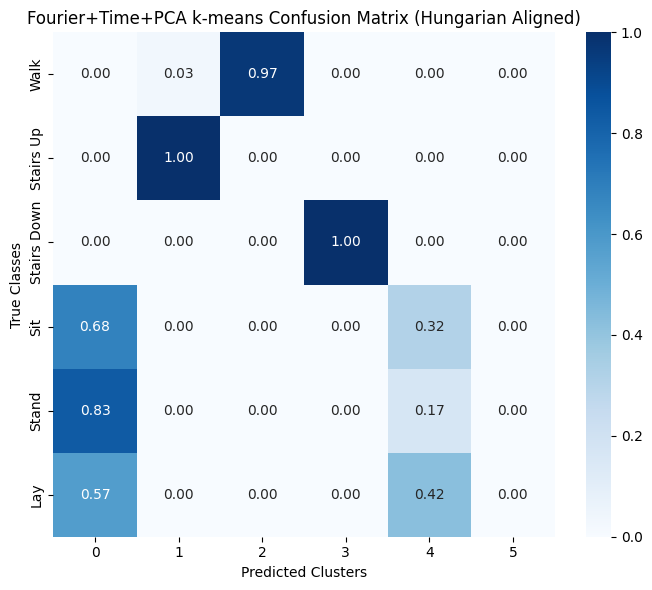

ARI=0.554  NMI=0.732  Sil=0.131  time=2.0s   -> 2025-11-14_13-31-32_seed42
--> k=6 | n_init=20 | max_iter=50 | n_fft=16 | n_comp=0.98 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-34_seed42


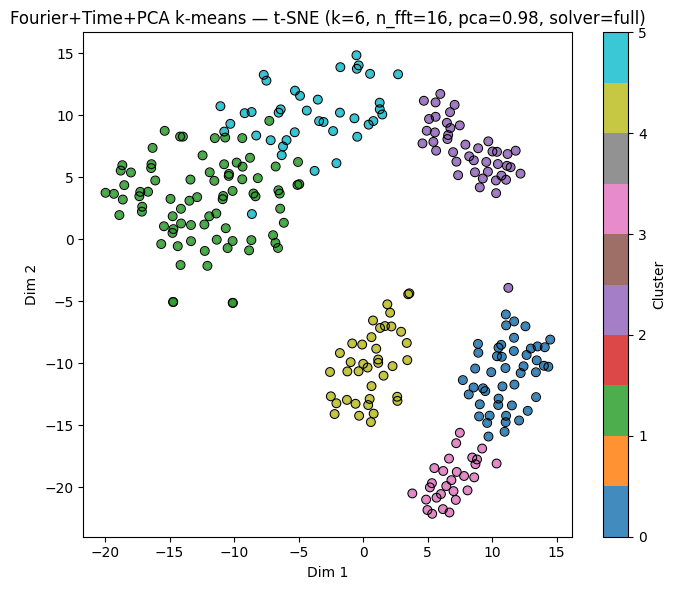

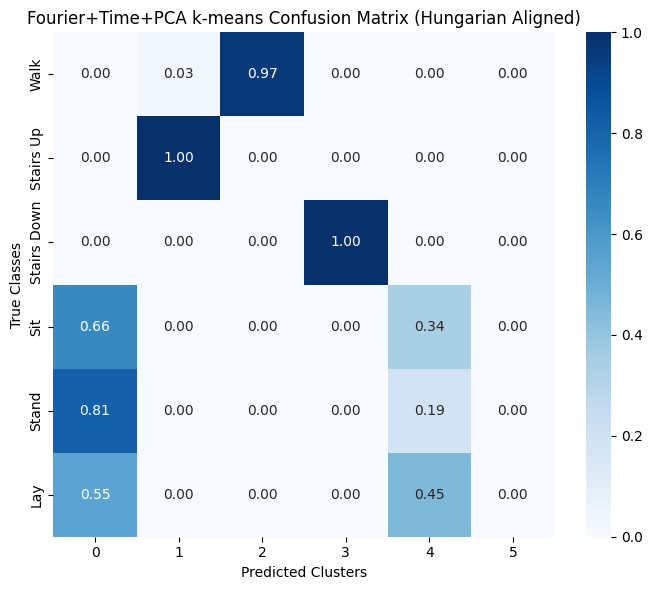

ARI=0.555  NMI=0.730  Sil=0.124  time=2.0s   -> 2025-11-14_13-31-34_seed42
--> k=6 | n_init=20 | max_iter=50 | n_fft=24 | n_comp=0.95 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-35_seed42


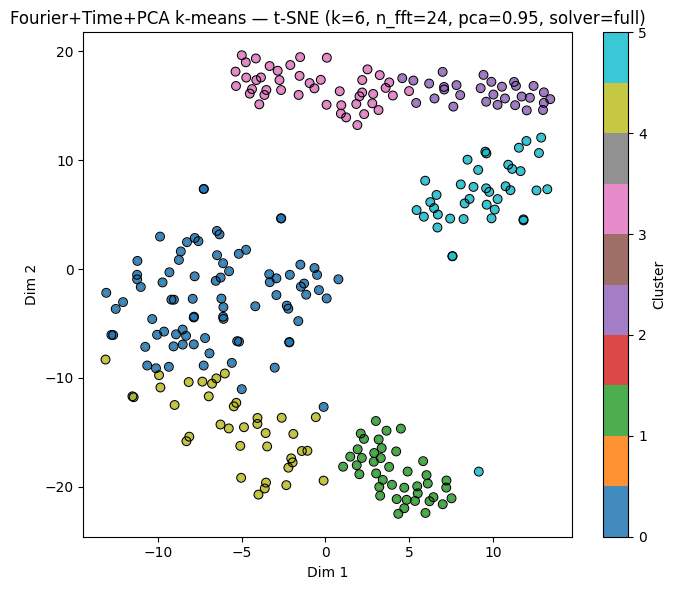

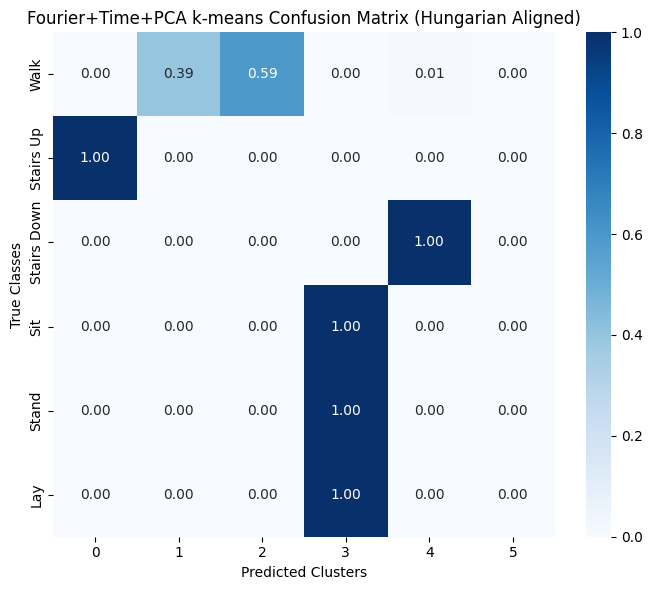

ARI=0.548  NMI=0.729  Sil=0.120  time=1.5s   -> 2025-11-14_13-31-35_seed42
--> k=6 | n_init=20 | max_iter=50 | n_fft=24 | n_comp=0.98 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-37_seed42


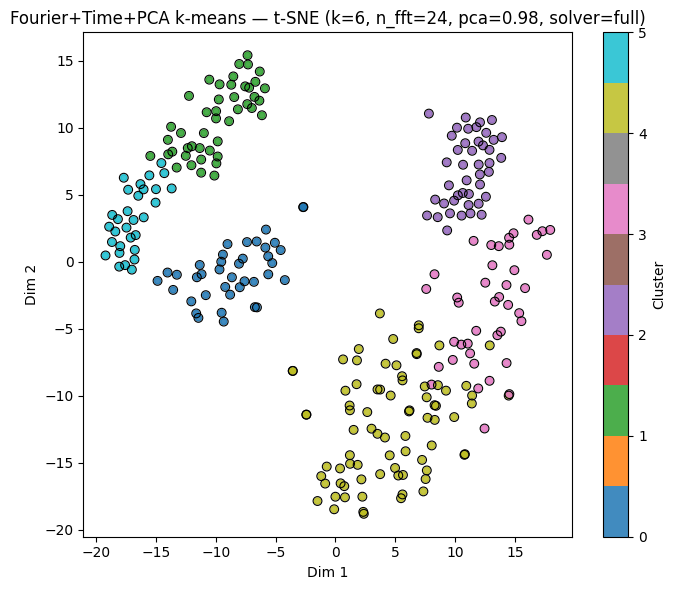

c:\projetsUniversite\Master_2\clustering\human_activity_clustering\notebooks\..\src\viz.py:352: RuntimeWarning: invalid value encountered in divide
  C_display = C_display / C_display.sum(axis=1, keepdims=True)


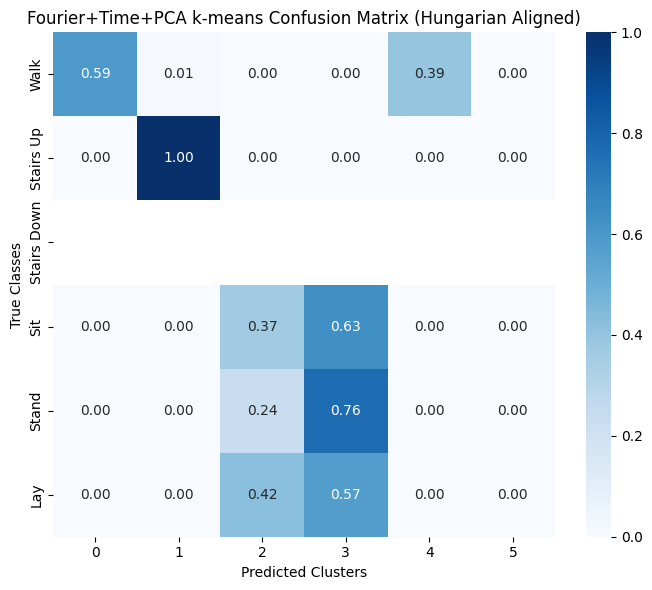

ARI=0.547  NMI=0.725  Sil=0.114  time=1.8s   -> 2025-11-14_13-31-37_seed42
--> k=6 | n_init=20 | max_iter=100 | n_fft=16 | n_comp=0.95 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-39_seed42


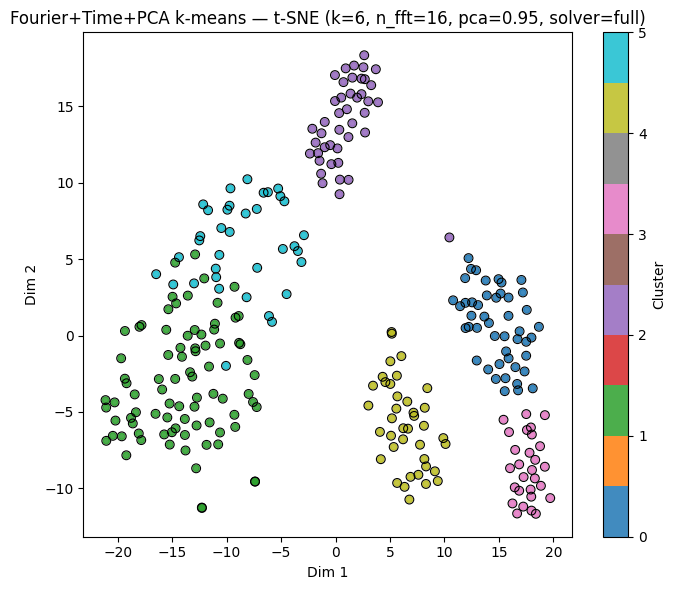

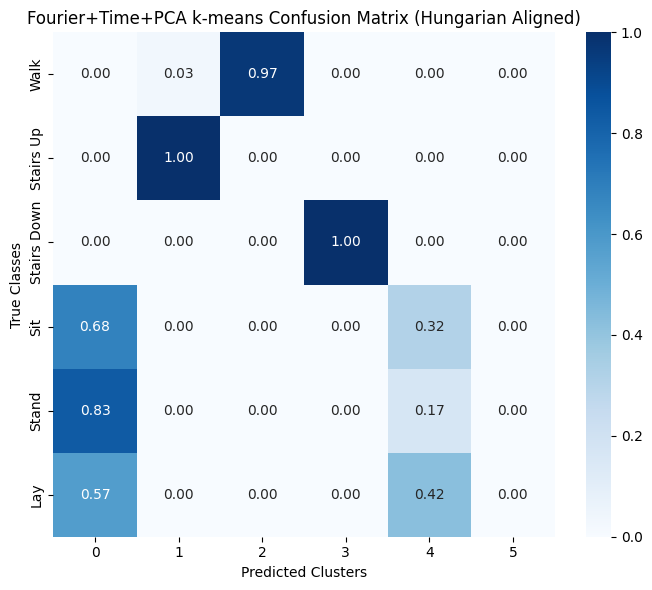

ARI=0.554  NMI=0.732  Sil=0.131  time=1.6s   -> 2025-11-14_13-31-39_seed42
--> k=6 | n_init=20 | max_iter=100 | n_fft=16 | n_comp=0.98 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-40_seed42


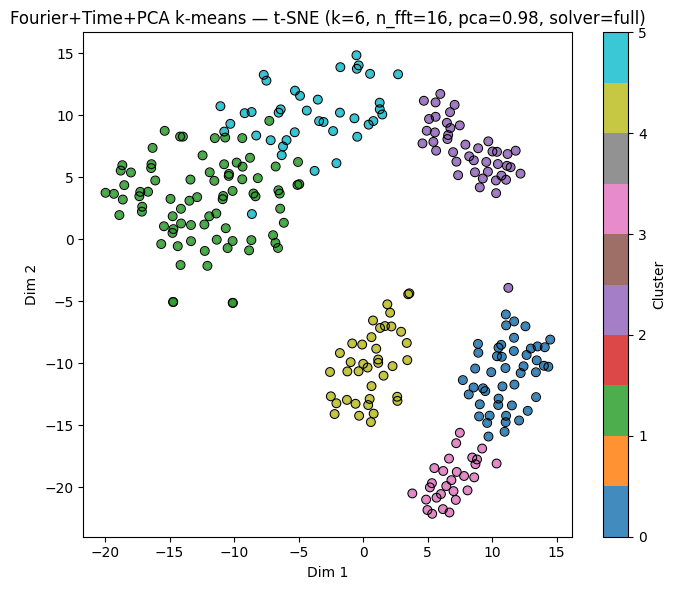

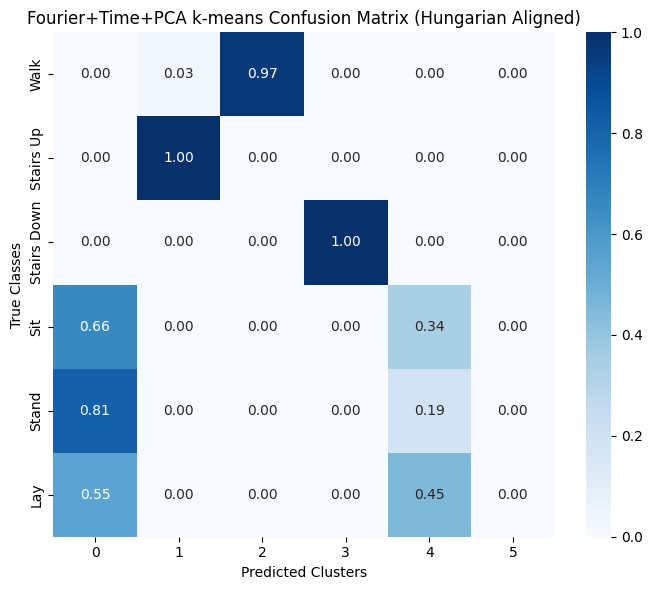

ARI=0.555  NMI=0.730  Sil=0.124  time=1.4s   -> 2025-11-14_13-31-40_seed42
--> k=6 | n_init=20 | max_iter=100 | n_fft=24 | n_comp=0.95 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-42_seed42


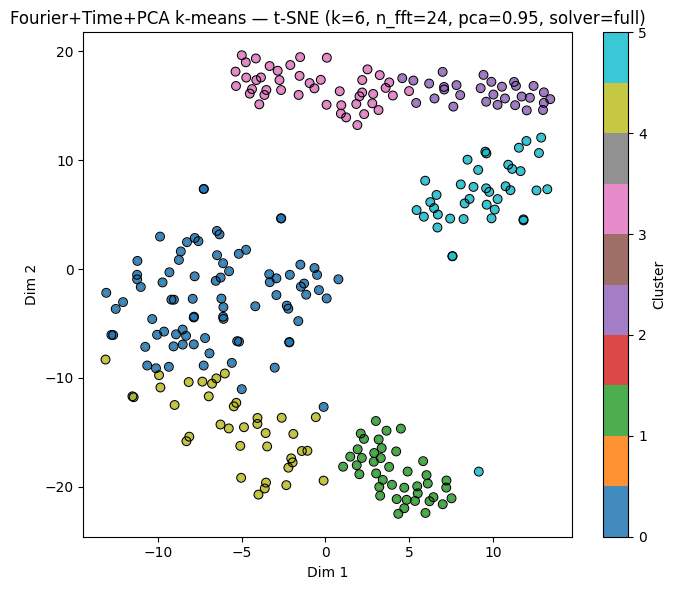

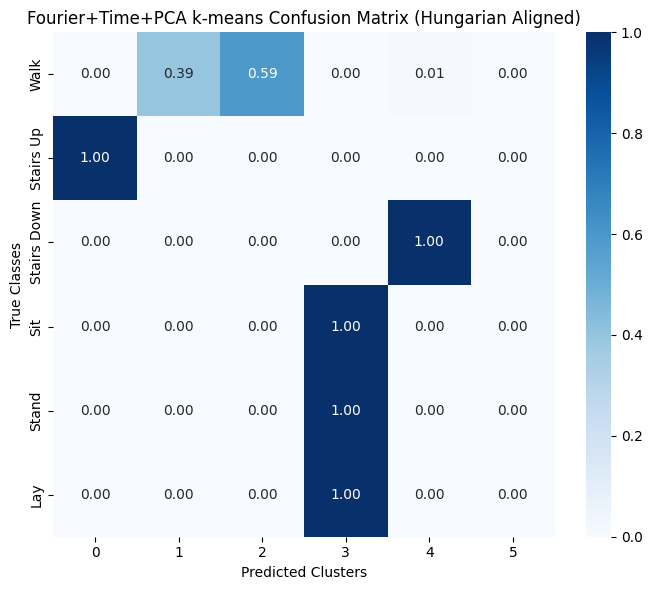

ARI=0.548  NMI=0.729  Sil=0.120  time=1.4s   -> 2025-11-14_13-31-42_seed42
--> k=6 | n_init=20 | max_iter=100 | n_fft=24 | n_comp=0.98 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-43_seed42


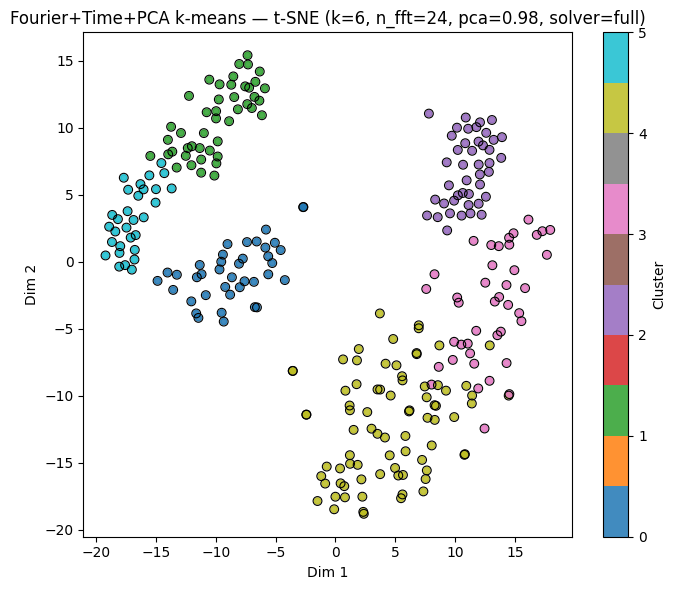

c:\projetsUniversite\Master_2\clustering\human_activity_clustering\notebooks\..\src\viz.py:352: RuntimeWarning: invalid value encountered in divide
  C_display = C_display / C_display.sum(axis=1, keepdims=True)


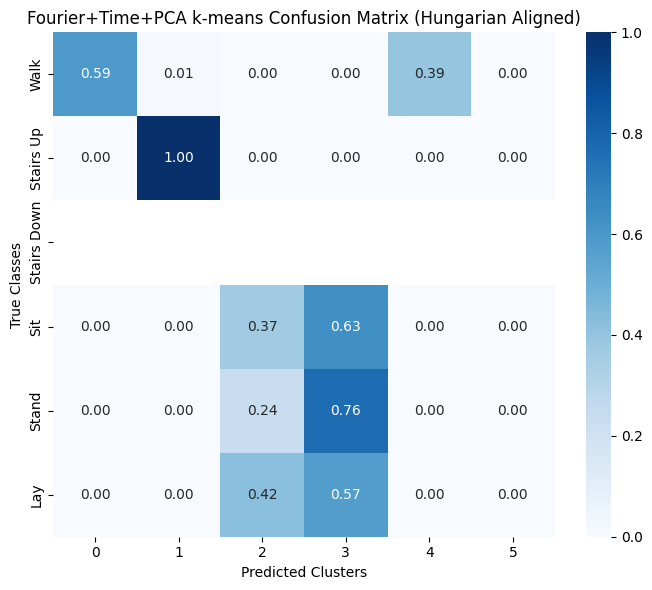

ARI=0.547  NMI=0.725  Sil=0.114  time=1.6s   -> 2025-11-14_13-31-43_seed42
--> k=6 | n_init=25 | max_iter=50 | n_fft=16 | n_comp=0.95 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-45_seed42


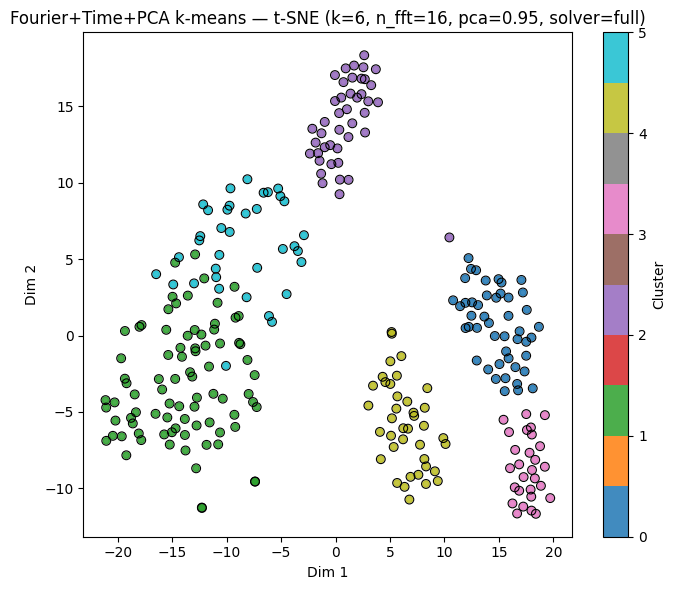

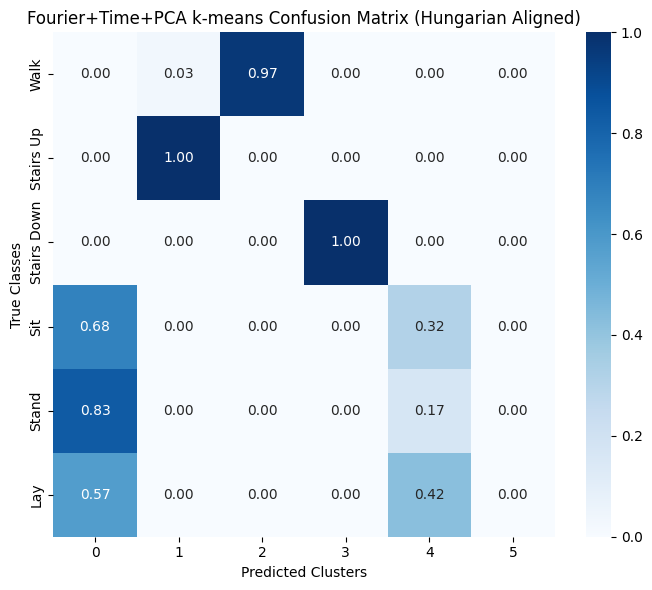

ARI=0.554  NMI=0.732  Sil=0.131  time=1.6s   -> 2025-11-14_13-31-45_seed42
--> k=6 | n_init=25 | max_iter=50 | n_fft=16 | n_comp=0.98 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-46_seed42


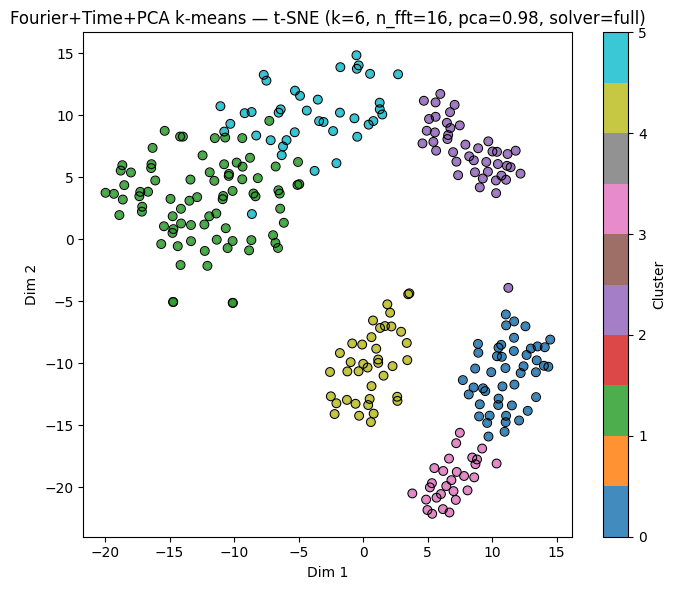

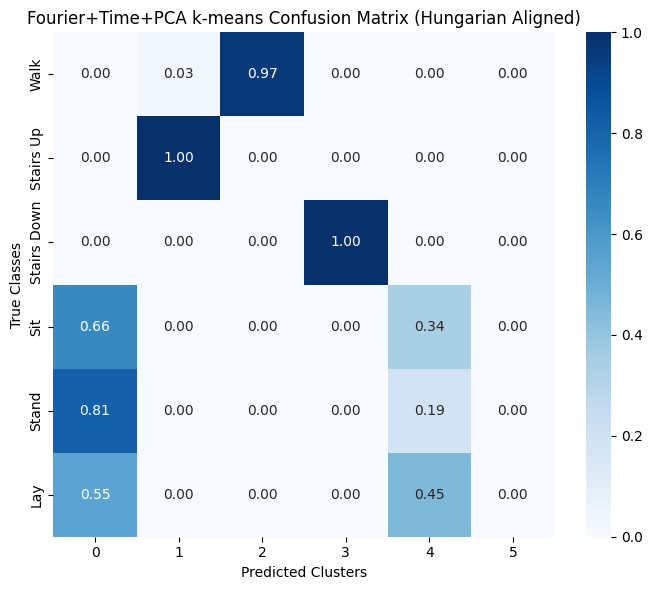

ARI=0.555  NMI=0.730  Sil=0.124  time=2.0s   -> 2025-11-14_13-31-46_seed42
--> k=6 | n_init=25 | max_iter=50 | n_fft=24 | n_comp=0.95 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-49_seed42


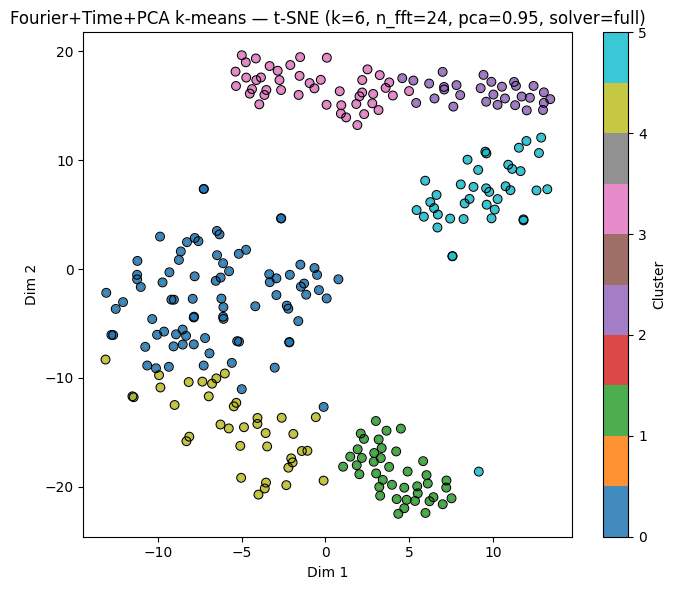

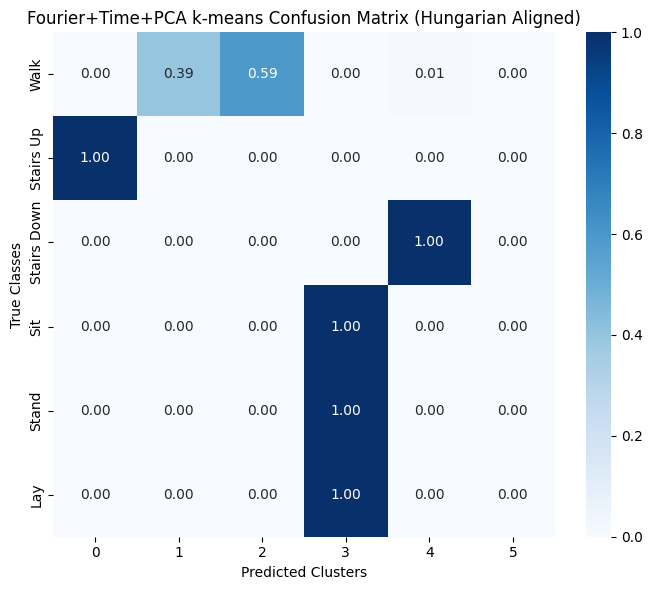

ARI=0.548  NMI=0.729  Sil=0.120  time=1.8s   -> 2025-11-14_13-31-49_seed42
--> k=6 | n_init=25 | max_iter=50 | n_fft=24 | n_comp=0.98 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-50_seed42


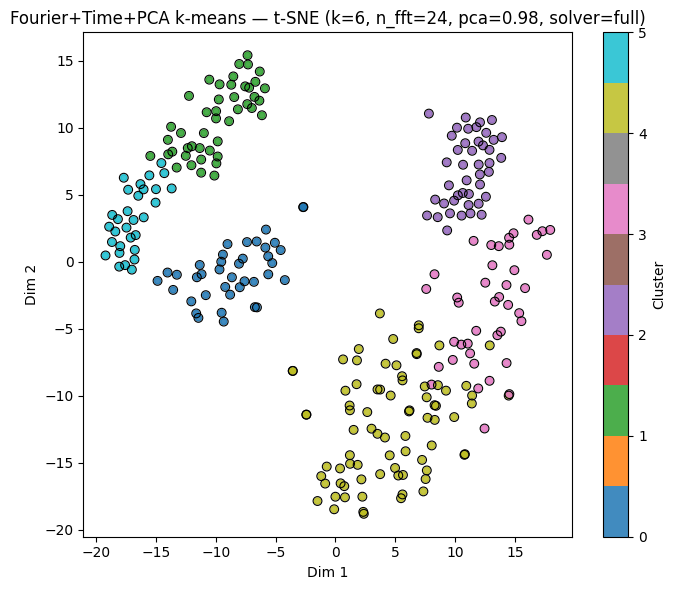

c:\projetsUniversite\Master_2\clustering\human_activity_clustering\notebooks\..\src\viz.py:352: RuntimeWarning: invalid value encountered in divide
  C_display = C_display / C_display.sum(axis=1, keepdims=True)


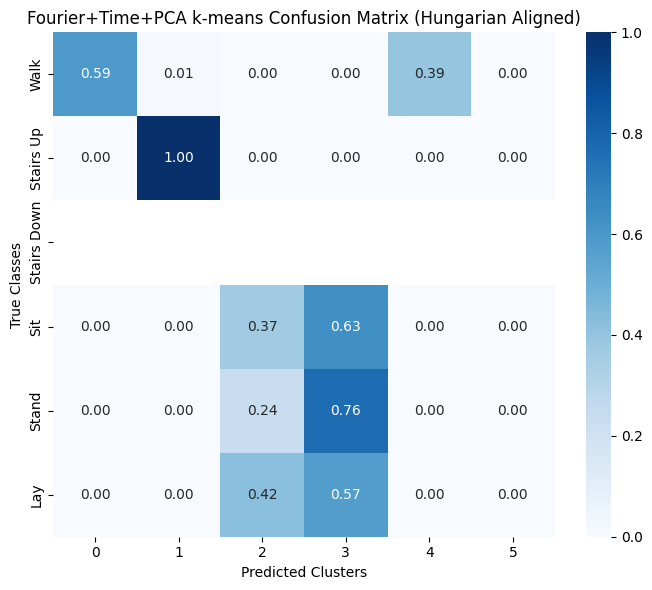

ARI=0.547  NMI=0.725  Sil=0.114  time=1.5s   -> 2025-11-14_13-31-50_seed42
--> k=6 | n_init=25 | max_iter=100 | n_fft=16 | n_comp=0.95 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-52_seed42


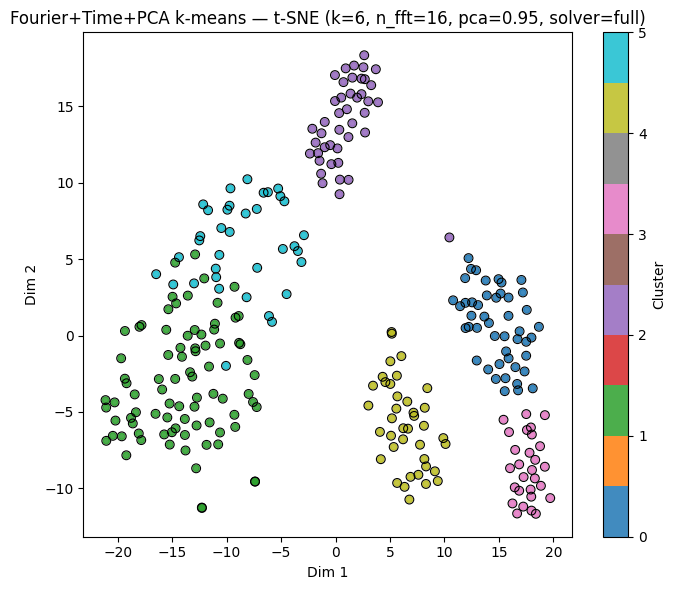

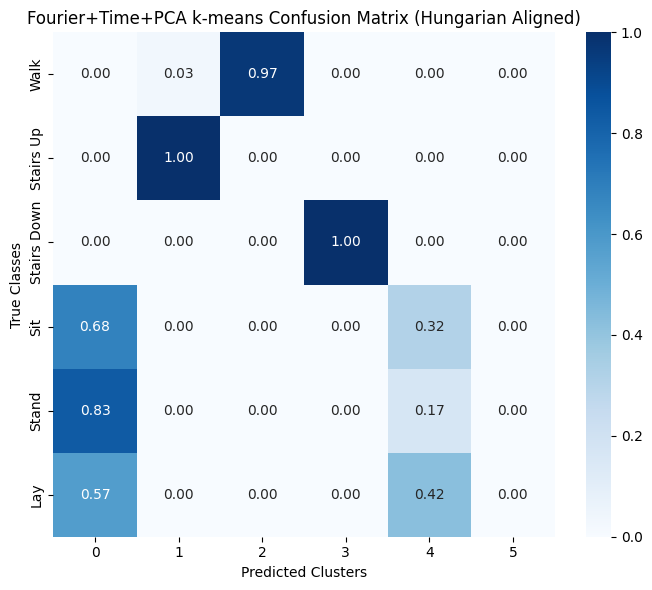

ARI=0.554  NMI=0.732  Sil=0.131  time=1.3s   -> 2025-11-14_13-31-52_seed42
--> k=6 | n_init=25 | max_iter=100 | n_fft=16 | n_comp=0.98 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-53_seed42


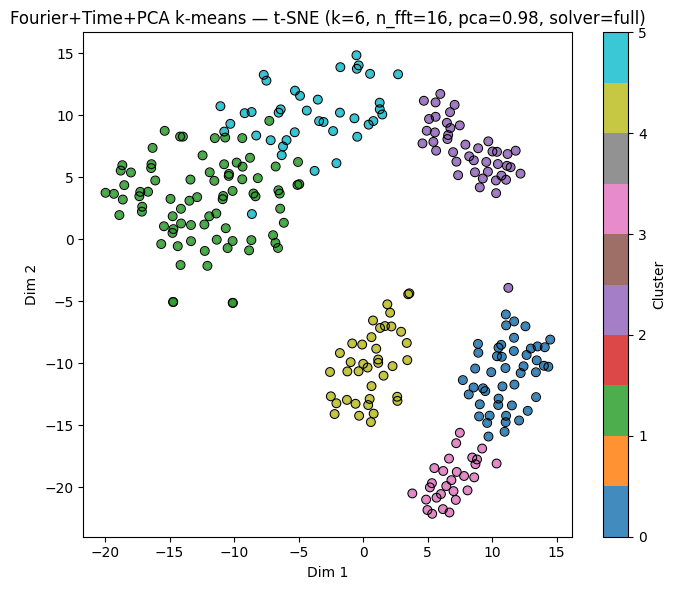

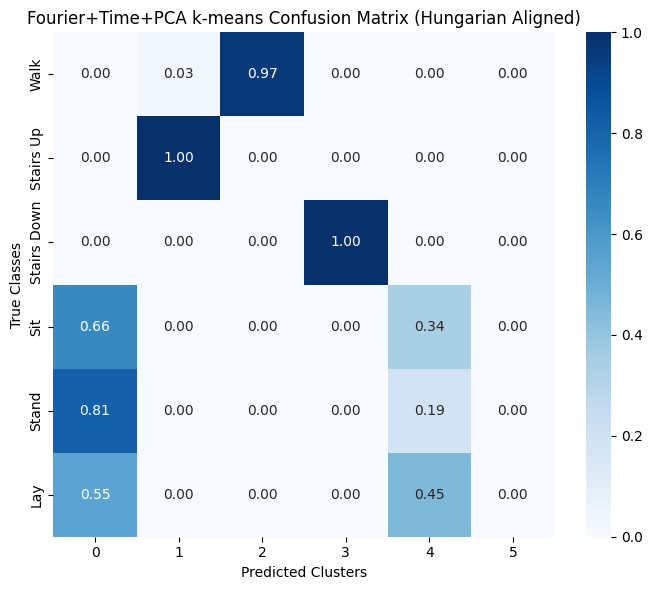

ARI=0.555  NMI=0.730  Sil=0.124  time=1.4s   -> 2025-11-14_13-31-53_seed42
--> k=6 | n_init=25 | max_iter=100 | n_fft=24 | n_comp=0.95 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-54_seed42


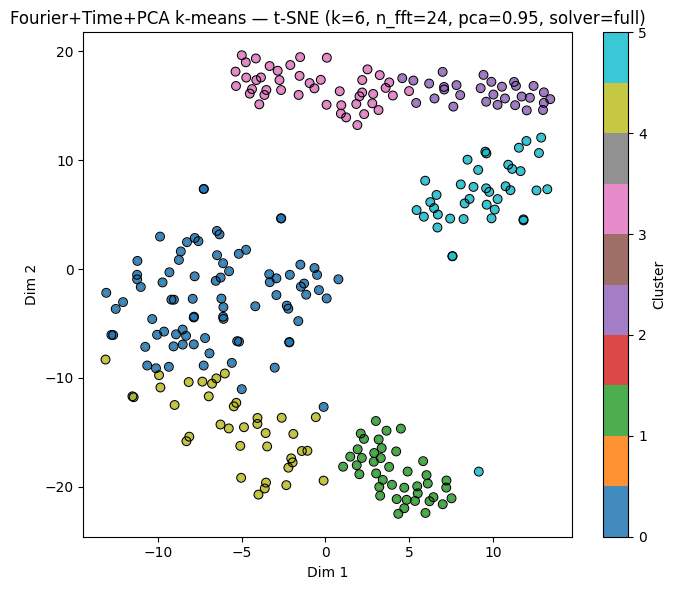

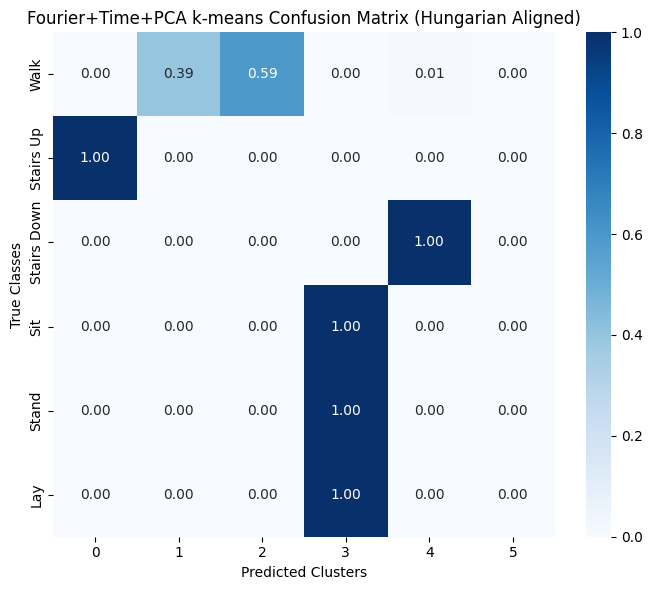

ARI=0.548  NMI=0.729  Sil=0.120  time=1.4s   -> 2025-11-14_13-31-54_seed42
--> k=6 | n_init=25 | max_iter=100 | n_fft=24 | n_comp=0.98 | svd=full | seed=42
✅ Saved run to: ../results\fourier_kmeans_2\2025-11-14_13-31-56_seed42


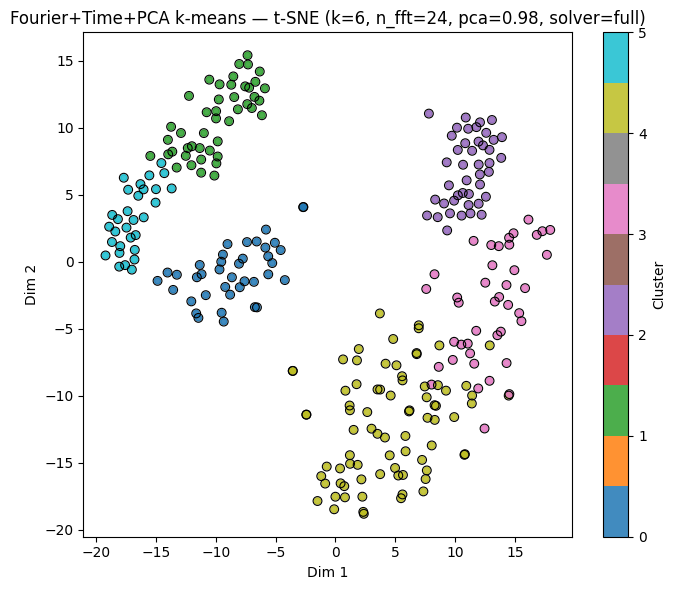

c:\projetsUniversite\Master_2\clustering\human_activity_clustering\notebooks\..\src\viz.py:352: RuntimeWarning: invalid value encountered in divide
  C_display = C_display / C_display.sum(axis=1, keepdims=True)


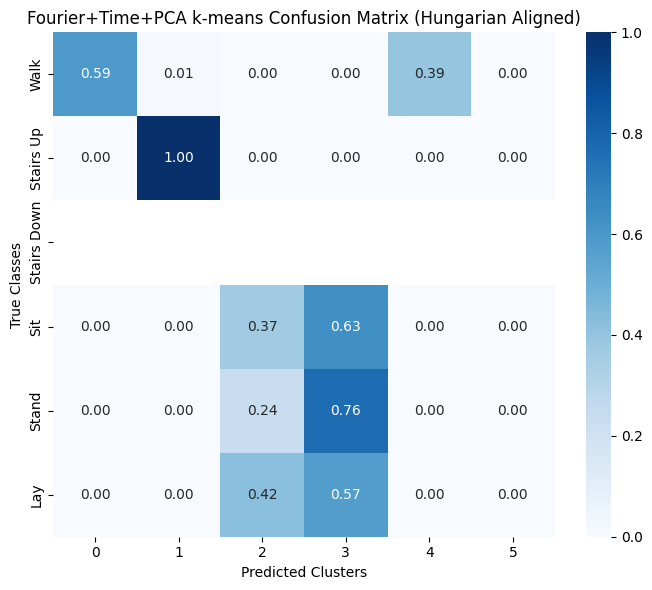

ARI=0.547  NMI=0.725  Sil=0.114  time=1.4s   -> 2025-11-14_13-31-56_seed42


In [10]:
results = []
for n_clusters, n_init, max_iter, n_fourier_coeffs, n_components, svd_solver, seed in product(
    N_CLUSTERS_LIST,
    N_INIT_LIST,
    MAX_ITER_LIST,
    N_FOURIER_COEFFS_LIST,
    N_COMPONENTS_LIST,
    SVD_SOLVER_LIST,
    RANDOM_SEEDS
):
    print(
        f"--> k={n_clusters} | n_init={n_init} | max_iter={max_iter} "
        f"| n_fft={n_fourier_coeffs} | n_comp={n_components} "
        f"| svd={svd_solver} | seed={seed}"
    )
    out = run_one(
        n_clusters=n_clusters,
        n_init=n_init,
        max_iter=max_iter,
        n_fourier_coeffs=n_fourier_coeffs,
        n_components=n_components,
        svd_solver=svd_solver,
        seed=seed
    )
    results.append(out)
    print(
        f"ARI={out['scores']['ARI']:.3f}  "
        f"NMI={out['scores']['NMI']:.3f}  "
        f"Sil={out['scores']['Silhouette_Euclidean']:.3f}  "
        f"time={out['time_sec']:.1f}s   -> {out['run_id']}"
    )

In [12]:
try:
    rows = []
    for r in results:
        row = {**r["params"], **r["scores"], "time_sec": r["time_sec"], "run_dir": r["run_dir"]}
        rows.append(row)
    df = pd.DataFrame(rows).sort_values(
        ["ARI", "NMI", "Silhouette_Euclidean"],
        ascending=False
    )
    display(df)
except Exception:
    print("Install pandas to get a sortable summary table.")


n_clusters  n_init  max_iter  n_fourier_coeffs  n_components svd_solver  \
1            6      15        50                16          0.98       full   
5            6      15       100                16          0.98       full   
9            6      20        50                16          0.98       full   
13           6      20       100                16          0.98       full   
17           6      25        50                16          0.98       full   
21           6      25       100                16          0.98       full   
0            6      15        50                16          0.95       full   
4            6      15       100                16          0.95       full   
8            6      20        50                16          0.95       full   
12           6      20       100                16          0.95       full   
16           6      25        50                16          0.95       full   
20           6      25       100                16          0.95       full   
2            6      15        50                24          0.95       full   
6            6      15       100                24          0.95       full   
10           6      20        50                24          0.95       full   
14           6      20       100                24          0.95       full   
18           6      25        50                24          0.95       full   
22           6      25       100                24          0.95       full   
3            6      15        50                24          0.98       full   
7            6      15       100                24          0.98       full   
11           6      20        50                24          0.98       full   
15           6      20       100                24          0.98       full   
19           6      25        50                24          0.98       full   
23           6      25       100                24          0.98       full   

    random_state             metric  sampling_rate       ARI       NMI  \
1             42  euclidean_fft_pca           51.2  0.554974  0.730435   
5             42  euclidean_fft_pca           51.2  0.554974  0.730435   
9             42  euclidean_fft_pca           51.2  0.554974  0.730435   
13            42  euclidean_fft_pca           51.2  0.554974  0.730435   
17            42  euclidean_fft_pca           51.2  0.554974  0.730435   
21            42  euclidean_fft_pca           51.2  0.554974  0.730435   
0             42  euclidean_fft_pca           51.2  0.554426  0.732488   
4             42  euclidean_fft_pca           51.2  0.554426  0.732488   
8             42  euclidean_fft_pca           51.2  0.554426  0.732488   
12            42  euclidean_fft_pca           51.2  0.554426  0.732488   
16            42  euclidean_fft_pca           51.2  0.554426  0.732488   
20            42  euclidean_fft_pca           51.2  0.554426  0.732488   
2             42  euclidean_fft_pca           51.2  0.547920  0.729063   
6             42  euclidean_fft_pca           51.2  0.547920  0.729063   
10            42  euclidean_fft_pca           51.2  0.547920  0.729063   
14            42  euclidean_fft_pca           51.2  0.547920  0.729063   
18            42  euclidean_fft_pca           51.2  0.547920  0.729063   
22            42  euclidean_fft_pca           51.2  0.547920  0.729063   
3             42  euclidean_fft_pca           51.2  0.546585  0.725470   
7             42  euclidean_fft_pca           51.2  0.546585  0.725470   
11            42  euclidean_fft_pca           51.2  0.546585  0.725470   
15            42  euclidean_fft_pca           51.2  0.546585  0.725470   
19            42  euclidean_fft_pca           51.2  0.546585  0.725470   
23            42  euclidean_fft_pca           51.2  0.546585  0.725470   

      Purity  Silhouette_Euclidean  time_sec  \
1   0.649819              0.123643  1.314837   
5   0.649819              0.123643  1.198218   
9   0.649819              0.12364